# 🌟 Real-World Example: PCA as Change of Basis

**The Connection:** In the previous notebooks, we learned about changing coordinate systems using basis matrices and similarity transforms. Now we'll see these concepts in action with **Principal Component Analysis (PCA)** - one of the most important applications in data science!

**The Real-World Problem:** Imagine you're a health researcher with data on people's height and weight. These measurements are naturally correlated (taller people tend to weigh more), creating a "diagonal cloud" when plotted. You want to:
- **Understand** the main patterns in your data
- **Compress** the data by keeping only the most important information
- **Remove noise** while preserving the essential structure

**How PCA Solves This:** PCA finds a new coordinate system (basis) where:
1. **First axis (PC1):** Points in the direction of maximum variation in your data
2. **Second axis (PC2):** Points in the direction of remaining variation, perpendicular to PC1
3. **The magic:** In this new coordinate system, your features become uncorrelated!

**What You'll Learn:**
- How to **compute the PCA basis** from real data using eigendecomposition
- How to **transform coordinates** between original and PCA spaces (change of basis!)
- How **similarity transforms** let us do operations in PCA space and map them back
- Why this is powerful for **compression, denoising, and data understanding**

**Key Insight:** PCA is just a smart way to choose an orthonormal basis that makes your data easier to understand and work with!

---

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Configure numpy display for cleaner output
np.set_printoptions(precision=4, suppress=True)

# Set up reproducible random numbers
rng = np.random.default_rng(42)  # Using same seed as other notebooks for consistency

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 10

print("📊 Libraries imported and configured!")
print("🎯 Ready to explore PCA as a change of basis operation!")

# Helper function from our previous notebook (adapted for this context)
def is_orthonormal(B, atol=1e-9):
    """Check if the columns of B form an orthonormal set."""
    Gram = B.T @ B
    return np.allclose(Gram, np.eye(B.shape[1]), atol=atol)

📊 Libraries imported and configured!
🎯 Ready to explore PCA as a change of basis operation!


## 🏗️ Step 1: Create Realistic Correlated Data

**The Scenario:** We're simulating a health dataset with **height** (cm) and **weight** (kg) measurements from 300 people.

**Why This Example?** 
- **Realistic correlation:** Taller people generally weigh more (positive correlation)
- **Real-world noise:** Not everyone follows the exact same height-weight relationship
- **Visual intuition:** Easy to understand and visualize in 2D

**Key Insight:** This correlation means our data forms a "diagonal cloud" rather than a circle. The natural coordinate system (height, weight) doesn't align with the data's main variation. PCA will find a better coordinate system!

**What to expect:** The data will form an elongated ellipse pointing from bottom-left to top-right, showing the height-weight correlation.

In [25]:
# Generate realistic height-weight data
n_people = 300

# Height: normally distributed around 175cm (about 5'9")
height = rng.normal(loc=175, scale=8, size=n_people)  # mean=175cm, std=8cm

# Weight: correlated with height + individual variation
# Base relationship: weight increases by ~0.9kg per cm of height above/below average
# Plus individual variation (metabolism, build, etc.)
base_weight = 70  # baseline weight for 175cm person
weight_per_cm = 0.9  # kg per cm above/below 175cm
individual_variation = rng.normal(loc=0, scale=5, size=n_people)  # ±5kg variation

weight = base_weight + weight_per_cm * (height - 175) + individual_variation

# Combine into data matrix (each row is one person)
X = np.column_stack([height, weight])  # Shape: (300, 2)

print(f"📏 Generated data for {n_people} people")
print(f"   Height: {height.min():.1f} to {height.max():.1f} cm")
print(f"   Weight: {weight.min():.1f} to {weight.max():.1f} kg")

# Center the data (subtract mean) - essential for PCA!
mean_height_weight = X.mean(axis=0)
X_centered = X - mean_height_weight

print(f"\n🎯 Original means: {mean_height_weight}")
print(f"   After centering: {X_centered.mean(axis=0)}")  # Should be ~[0, 0]
print(f"\n📊 Sample of centered data (first 5 people):")
print(f"   [height_diff, weight_diff]")
for i in range(5):
    print(f"   Person {i+1}: [{X_centered[i,0]:6.1f}, {X_centered[i,1]:6.1f}]")

📏 Generated data for 300 people
   Height: 154.5 to 198.3 cm
   Weight: 40.4 to 95.4 kg

🎯 Original means: [174.6714  69.648 ]
   After centering: [-0. -0.]

📊 Sample of centered data (first 5 people):
   [height_diff, weight_diff]
   Person 1: [   2.8,   11.2]
   Person 2: [  -8.0,  -14.8]
   Person 3: [   6.3,   10.1]
   Person 4: [   7.9,    5.5]
   Person 5: [ -15.3,  -14.0]


### 📈 Visualizing the Raw Data

**What to Look For:**
- **Diagonal trend:** Data forms an elongated cloud from bottom-left to top-right
- **Correlation:** Positive relationship between height and weight
- **Natural axes problem:** The x and y axes (height, weight) don't align with the data's main variation

**Why We Center:** PCA finds directions of maximum variance from the center of the data. By centering, we ensure these directions point through the data cloud, not towards some arbitrary offset.

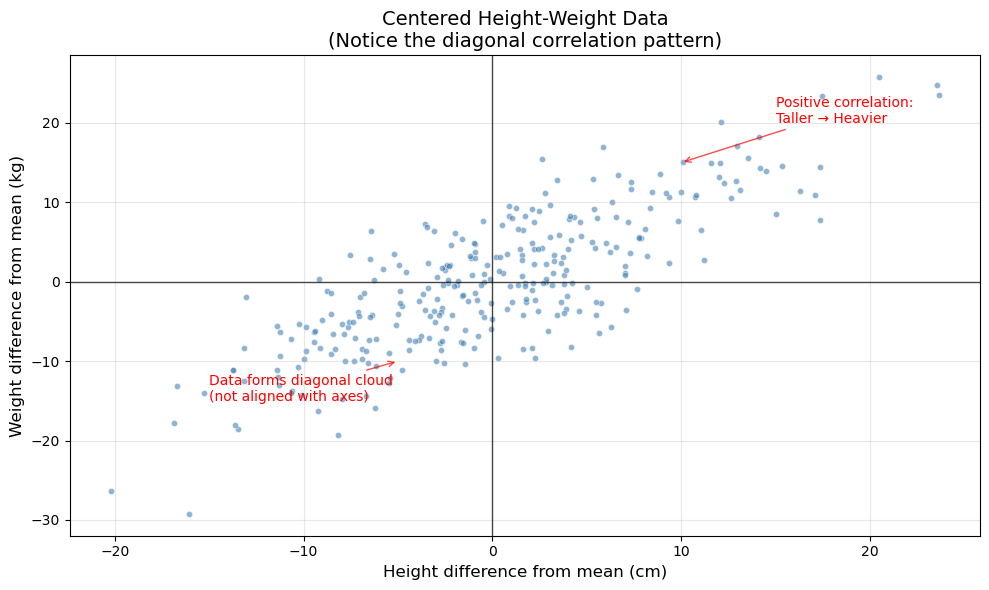

📊 Correlation coefficient: 0.804
   (Values close to 1 indicate strong positive correlation)
   This confirms what we see visually - the diagonal pattern!


In [26]:
plt.figure(figsize=(10, 6))

# Main scatter plot
plt.scatter(X_centered[:,0], X_centered[:,1], s=20, alpha=0.6, color='steelblue', 
           edgecolors='white', linewidth=0.5)

# Add reference lines
plt.axhline(0, color='black', linewidth=1, alpha=0.7, linestyle='-')
plt.axvline(0, color='black', linewidth=1, alpha=0.7, linestyle='-')

# Add grid for easier reading
plt.grid(True, alpha=0.3)

# Labels and title
plt.xlabel("Height difference from mean (cm)", fontsize=12)
plt.ylabel("Weight difference from mean (kg)", fontsize=12)
plt.title("Centered Height-Weight Data\n(Notice the diagonal correlation pattern)", fontsize=14)

# Add some annotations to explain what we see
plt.annotate("Positive correlation:\nTaller → Heavier", 
             xy=(10, 15), xytext=(15, 20),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, color='red')

plt.annotate("Data forms diagonal cloud\n(not aligned with axes)", 
             xy=(-5, -10), xytext=(-15, -15),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Calculate and display correlation
correlation = np.corrcoef(X_centered.T)[0,1]
print(f"📊 Correlation coefficient: {correlation:.3f}")
print(f"   (Values close to 1 indicate strong positive correlation)")
print(f"   This confirms what we see visually - the diagonal pattern!")

## 🧮 Step 2: Computing the PCA Basis - The Mathematical Recipe

**The Goal:** Find a new orthonormal basis where our data has maximum variance along the first axis, and remaining variance along the second axis.

**The Mathematical Recipe:**
1. **Compute covariance matrix:** `C = (1/n) × X_centered^T × X_centered`
2. **Find eigenvectors and eigenvalues:** `C × v = λ × v`
3. **Sort by eigenvalues:** Largest eigenvalue → most important direction
4. **Basis matrix B:** Columns are the eigenvectors (principal components)

**Why This Works:**
- **Covariance matrix** captures how variables change together
- **Eigenvectors** point in directions of pure variance (no correlation)
- **Eigenvalues** tell us how much variance exists in each direction
- **Orthonormal basis:** The eigenvectors are perpendicular and unit length

**Connection to Previous Notebooks:** This is exactly the type of orthonormal basis we learned about! We'll use `B^T` to transform coordinates (since `B^(-1) = B^T` for orthonormal matrices).

In [27]:
# Step 1: Compute the covariance matrix
# This measures how height and weight vary together
print("🔢 Step 1: Computing covariance matrix")
print("="*40)

covariance_matrix = np.cov(X_centered, rowvar=False)  # rowvar=False: variables in columns
print("Covariance matrix C:")
print(covariance_matrix)
print(f"\nInterpretation:")
print(f"  C[0,0] = {covariance_matrix[0,0]:.2f} → Height variance")
print(f"  C[1,1] = {covariance_matrix[1,1]:.2f} → Weight variance") 
print(f"  C[0,1] = {covariance_matrix[0,1]:.2f} → Height-Weight covariance (correlation)")

# Step 2: Eigendecomposition
print(f"\n🎯 Step 2: Finding principal directions (eigenvectors)")
print("="*50)

# Use eigh for symmetric matrices (more stable)
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Sort in descending order (most important first)
sort_indices = eigenvalues.argsort()[::-1]
eigenvalues_sorted = eigenvalues[sort_indices]
eigenvectors_sorted = eigenvectors[:, sort_indices]

# This is our PCA basis matrix B
B_pca = eigenvectors_sorted

print("Eigenvalues (variance in each principal direction):")
print(f"  λ₁ = {eigenvalues_sorted[0]:.2f} (Principal Component 1)")
print(f"  λ₂ = {eigenvalues_sorted[1]:.2f} (Principal Component 2)")
print(f"  Ratio: {eigenvalues_sorted[0]/eigenvalues_sorted[1]:.1f}:1")

print(f"\nPrincipal directions (basis vectors):")
print("B = [PC1  PC2]")
print(B_pca)

# Step 3: Verify orthonormality
print(f"\n✅ Step 3: Verify this is an orthonormal basis")
print("="*45)
print(f"Is B orthonormal? {is_orthonormal(B_pca)}")
print(f"B^T @ B = \n{np.round(B_pca.T @ B_pca, 4)}")
print("(Should be identity matrix)")

# Show variance explained
total_variance = eigenvalues_sorted.sum()
print(f"\n📊 Variance Explained:")
print(f"  PC1: {100 * eigenvalues_sorted[0]/total_variance:.1f}%")
print(f"  PC2: {100 * eigenvalues_sorted[1]/total_variance:.1f}%")
print(f"  Total: {100 * total_variance/total_variance:.1f}%")

🔢 Step 1: Computing covariance matrix
Covariance matrix C:
[[55.386  51.0795]
 [51.0795 72.9282]]

Interpretation:
  C[0,0] = 55.39 → Height variance
  C[1,1] = 72.93 → Weight variance
  C[0,1] = 51.08 → Height-Weight covariance (correlation)

🎯 Step 2: Finding principal directions (eigenvectors)
Eigenvalues (variance in each principal direction):
  λ₁ = 115.98 (Principal Component 1)
  λ₂ = 12.33 (Principal Component 2)
  Ratio: 9.4:1

Principal directions (basis vectors):
B = [PC1  PC2]
[[ 0.6445 -0.7646]
 [ 0.7646  0.6445]]

✅ Step 3: Verify this is an orthonormal basis
Is B orthonormal? True
B^T @ B = 
[[ 1. -0.]
 [-0.  1.]]
(Should be identity matrix)

📊 Variance Explained:
  PC1: 90.4%
  PC2: 9.6%
  Total: 100.0%


### 🎨 Visualizing the Principal Axes

**What You'll See:**
- **Red arrow (PC1):** Points along the main direction of data spread (maximum variance)
- **Blue arrow (PC2):** Points perpendicular to PC1 (remaining variance)
- **Key insight:** These arrows show our new coordinate system!

**Connection to Previous Notebooks:** 
- These arrows are our basis vectors `b₁` and `b₂`
- They form an orthonormal basis (perpendicular and unit length)
- We can transform any point from (height, weight) coordinates to (PC1, PC2) coordinates

**Why This is Better:** In the new coordinate system, the data will be "unrotated" - aligned with the axes instead of diagonal.

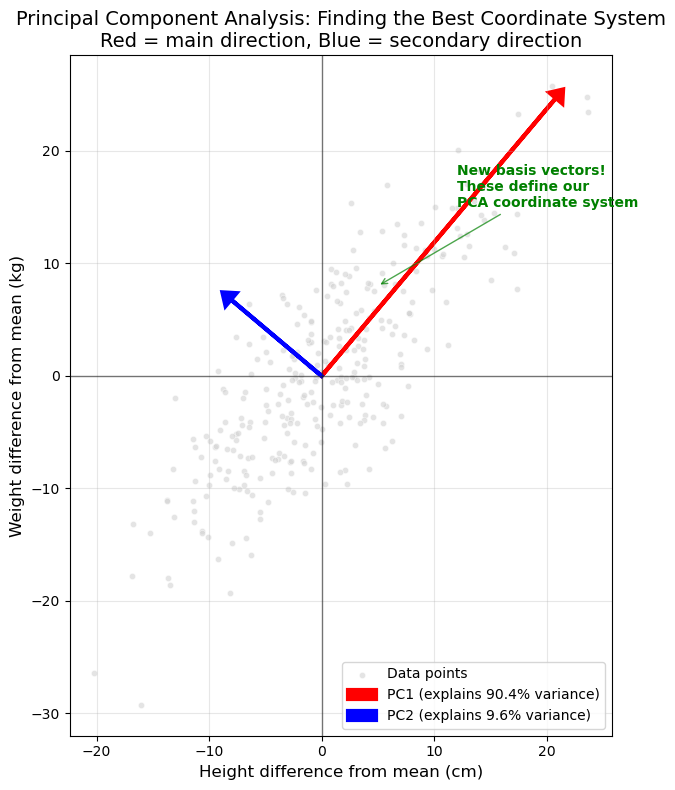

🎯 Our new orthonormal basis B:
   PC1 direction: [ 0.645,  0.765]
   PC2 direction: [-0.765,  0.645]

📐 Verification:
   PC1 · PC2 = 0.000000 (should be ~0)
   |PC1| = 1.000000 (should be 1)
   |PC2| = 1.000000 (should be 1)


In [28]:
plt.figure(figsize=(12, 8))

# Plot the data points
plt.scatter(X_centered[:,0], X_centered[:,1], s=20, alpha=0.6, color='lightgray', 
           edgecolors='white', linewidth=0.5, label='Data points')

# Calculate arrow lengths proportional to sqrt(eigenvalues) for visual clarity
arrow_scale = 3  # Adjust for visibility
pc1_length = arrow_scale * np.sqrt(eigenvalues_sorted[0])
pc2_length = arrow_scale * np.sqrt(eigenvalues_sorted[1])

# Draw principal component vectors from origin
origin = np.array([0.0, 0.0])

# PC1 direction (red arrow)
pc1_direction = B_pca[:, 0] * pc1_length
plt.arrow(origin[0], origin[1], pc1_direction[0], pc1_direction[1], 
          head_width=1.5, head_length=1.0, fc='red', ec='red', linewidth=3,
          label=f'PC1 (explains {100*eigenvalues_sorted[0]/total_variance:.1f}% variance)')

# PC2 direction (blue arrow) 
pc2_direction = B_pca[:, 1] * pc2_length
plt.arrow(origin[0], origin[1], pc2_direction[0], pc2_direction[1], 
          head_width=1.5, head_length=1.0, fc='blue', ec='blue', linewidth=3,
          label=f'PC2 (explains {100*eigenvalues_sorted[1]/total_variance:.1f}% variance)')

# Add reference lines
plt.axhline(0, color='black', linewidth=1, alpha=0.5)
plt.axvline(0, color='black', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)

# Labels and formatting
plt.xlabel("Height difference from mean (cm)", fontsize=12)
plt.ylabel("Weight difference from mean (kg)", fontsize=12)
plt.title("Principal Component Analysis: Finding the Best Coordinate System\n" + 
          "Red = main direction, Blue = secondary direction", fontsize=14)
plt.legend(fontsize=10)

# Add annotations
plt.annotate("New basis vectors!\nThese define our\nPCA coordinate system", 
             xy=(5, 8), xytext=(12, 15),
             arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
             fontsize=10, color='green', weight='bold')

plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Print the basis vectors for reference
print("🎯 Our new orthonormal basis B:")
print(f"   PC1 direction: [{B_pca[0,0]:6.3f}, {B_pca[1,0]:6.3f}]")
print(f"   PC2 direction: [{B_pca[0,1]:6.3f}, {B_pca[1,1]:6.3f}]")
print(f"\n📐 Verification:")
print(f"   PC1 · PC2 = {np.dot(B_pca[:,0], B_pca[:,1]):.6f} (should be ~0)")
print(f"   |PC1| = {np.linalg.norm(B_pca[:,0]):.6f} (should be 1)")
print(f"   |PC2| = {np.linalg.norm(B_pca[:,1]):.6f} (should be 1)")

## 🔄 Step 3: Change of Basis - From (Height, Weight) to (PC1, PC2)

**The Transformation:** Now we'll transform our data from the original coordinate system to the PCA coordinate system.

**Mathematical Recipe:**
```
Original coordinates: (height_diff, weight_diff)
PCA coordinates:      (PC1_score, PC2_score)

Transformation: Z = X_centered @ B
```

**Why This Works:**
- Since `B` is orthonormal, we use the formula from our previous notebook
- Each row of `Z` gives one person's coordinates in the PCA basis
- `PC1_score`: How much they project onto the main direction
- `PC2_score`: How much they project onto the secondary direction

**Expected Result:**
- **Uncorrelated features:** PC1 and PC2 will have zero correlation
- **Aligned with axes:** The data cloud will align with the new coordinate axes
- **Ordered importance:** PC1 has more variance than PC2

**Connection to Previous Notebooks:** This is exactly the coordinate transformation `v_basis = B^T @ v_world` we learned about!

In [29]:
# Transform to PCA coordinates using our orthonormal basis
print("🔄 Transforming to PCA Coordinate System")
print("="*45)

# Method 1: Direct matrix multiplication (since B is orthonormal)
Z_pca = X_centered @ B_pca  # Each row is now [PC1_score, PC2_score]

# Method 2: Using transpose (equivalent for orthonormal matrices)
Z_pca_alt = X_centered @ B_pca  # Same as B_pca.T @ X_centered.T, but for row vectors

print("Sample transformations (first 5 people):")
print("Original (height_diff, weight_diff) → PCA (PC1, PC2)")
print("-" * 55)
for i in range(5):
    print(f"Person {i+1}: [{X_centered[i,0]:6.1f}, {X_centered[i,1]:6.1f}] → [{Z_pca[i,0]:6.1f}, {Z_pca[i,1]:6.1f}]")

# Verify the transformation worked correctly
print(f"\n✅ Verification:")
print(f"   Shape of Z_pca: {Z_pca.shape} (should be {X_centered.shape})")
print(f"   Mean of PC1: {Z_pca[:,0].mean():.6f} (should be ~0)")
print(f"   Mean of PC2: {Z_pca[:,1].mean():.6f} (should be ~0)")

# Check covariance in PCA space
cov_pca = np.cov(Z_pca, rowvar=False)
print(f"\n📊 Covariance matrix in PCA space:")
print(np.round(cov_pca, 4))
print("Key insights:")
print(f"  • PC1 variance: {cov_pca[0,0]:.2f} (should equal λ₁ = {eigenvalues_sorted[0]:.2f})")
print(f"  • PC2 variance: {cov_pca[1,1]:.2f} (should equal λ₂ = {eigenvalues_sorted[1]:.2f})")
print(f"  • PC1-PC2 covariance: {cov_pca[0,1]:.6f} (should be ~0 = uncorrelated!)")

# Correlation check
correlation_pca = np.corrcoef(Z_pca.T)[0,1]
print(f"\n🎯 Correlation in PCA space: {correlation_pca:.6f}")
print("   (Nearly zero confirms features are uncorrelated!)")

🔄 Transforming to PCA Coordinate System
Sample transformations (first 5 people):
Original (height_diff, weight_diff) → PCA (PC1, PC2)
-------------------------------------------------------
Person 1: [   2.8,   11.2] → [  10.3,    5.1]
Person 2: [  -8.0,  -14.8] → [ -16.5,   -3.4]
Person 3: [   6.3,   10.1] → [  11.8,    1.7]
Person 4: [   7.9,    5.5] → [   9.3,   -2.5]
Person 5: [ -15.3,  -14.0] → [ -20.6,    2.7]

✅ Verification:
   Shape of Z_pca: (300, 2) (should be (300, 2))
   Mean of PC1: -0.000000 (should be ~0)
   Mean of PC2: 0.000000 (should be ~0)

📊 Covariance matrix in PCA space:
[[115.9841  -0.    ]
 [ -0.      12.33  ]]
Key insights:
  • PC1 variance: 115.98 (should equal λ₁ = 115.98)
  • PC2 variance: 12.33 (should equal λ₂ = 12.33)
  • PC1-PC2 covariance: -0.000000 (should be ~0 = uncorrelated!)

🎯 Correlation in PCA space: -0.000000
   (Nearly zero confirms features are uncorrelated!)


### 🎨 Visualizing Data in PCA Space

**The Magic Revealed:** In this plot, you'll see the power of choosing the right basis!

**What to Expect:**
- **Aligned with axes:** The data cloud now aligns with PC1 and PC2 axes
- **No correlation:** No diagonal pattern - features are uncorrelated
- **Different spreads:** PC1 has more spread than PC2 (reflects eigenvalues)

**Key Insight:** Same data, same geometric relationships, but now the coordinate system makes the structure obvious! This is the power of choosing an orthonormal basis that "respects" your data's natural patterns.

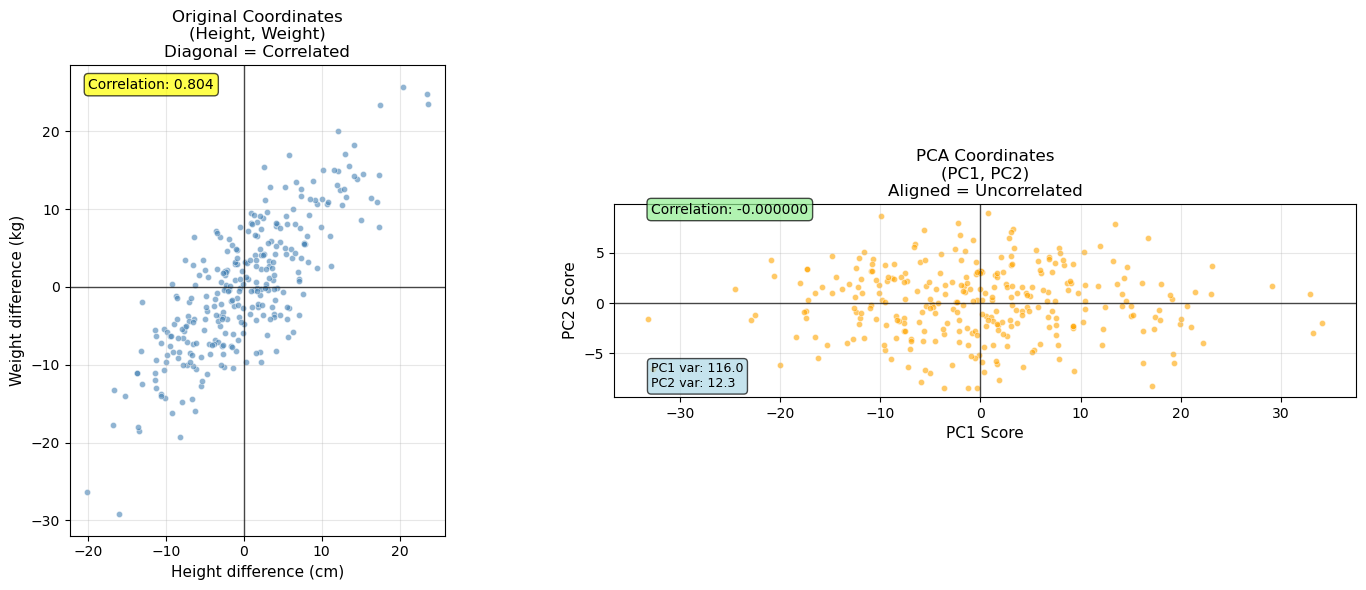

🎯 Transformation Success!
Left plot:  Data diagonal (correlated) in original coordinates
Right plot: Data aligned with axes (uncorrelated) in PCA coordinates

💡 Key Insight: Same geometric data, different coordinate system!
   The change of basis revealed the data's natural structure!


In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Original coordinate system
ax1.scatter(X_centered[:,0], X_centered[:,1], s=20, alpha=0.6, color='steelblue', 
           edgecolors='white', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=1, alpha=0.7)
ax1.axvline(0, color='black', linewidth=1, alpha=0.7)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("Height difference (cm)", fontsize=11)
ax1.set_ylabel("Weight difference (kg)", fontsize=11)
ax1.set_title("Original Coordinates\n(Height, Weight)\nDiagonal = Correlated", fontsize=12)
ax1.set_aspect('equal', adjustable='box')

# Add correlation text
ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Right plot: PCA coordinate system  
ax2.scatter(Z_pca[:,0], Z_pca[:,1], s=20, alpha=0.6, color='orange',
           edgecolors='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=1, alpha=0.7)
ax2.axvline(0, color='black', linewidth=1, alpha=0.7)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel("PC1 Score", fontsize=11)
ax2.set_ylabel("PC2 Score", fontsize=11)
ax2.set_title("PCA Coordinates\n(PC1, PC2)\nAligned = Uncorrelated", fontsize=12)
ax2.set_aspect('equal', adjustable='box')

# Add correlation text
ax2.text(0.05, 0.95, f'Correlation: {correlation_pca:.6f}', 
         transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# Add variance information
ax2.text(0.05, 0.05, f'PC1 var: {eigenvalues_sorted[0]:.1f}\nPC2 var: {eigenvalues_sorted[1]:.1f}', 
         transform=ax2.transAxes, fontsize=9,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

print("🎯 Transformation Success!")
print("="*30)
print("Left plot:  Data diagonal (correlated) in original coordinates")
print("Right plot: Data aligned with axes (uncorrelated) in PCA coordinates")
print("\n💡 Key Insight: Same geometric data, different coordinate system!")
print("   The change of basis revealed the data's natural structure!")

## 🗜️ Step 4: Data Compression Using Similarity Transforms

**The Big Idea:** Now that we have our data in PCA coordinates, we can do something powerful - **remove the less important dimension** (PC2) and keep only the most important one (PC1).

**Why This Works:**
- **In PCA space:** Simply set PC2 = 0 (trivial operation!)
- **In original space:** This becomes a complex projection operation
- **The connection:** Similarity transforms let us do simple operations in one coordinate system and see the results in another

**Mathematical Recipe:**
1. **Compress in PCA space:** `Z_compressed = [PC1_scores, 0]`
2. **Transform back:** `X_reconstructed = Z_compressed @ B^T`
3. **Add mean back:** `X_final = X_reconstructed + mean`

**Expected Result:** The data will be projected onto a line that captures the main height-weight relationship, removing noise in the secondary direction.

**Connection to Previous Notebooks:** This is exactly the similarity transform pattern `B^(-1) @ T @ B` we learned about, where `T` is the "keep only PC1" operation!

In [31]:
print("🗜️ Data Compression: Keeping Only PC1")
print("="*40)

# Step 1: Compress in PCA space (simple!)
Z_compressed = Z_pca.copy()
Z_compressed[:, 1] = 0.0  # Set PC2 = 0, keep only PC1

print("Sample compression (first 5 people):")
print("Original PCA → Compressed PCA")
print("-" * 35)
for i in range(5):
    print(f"[{Z_pca[i,0]:6.1f}, {Z_pca[i,1]:6.1f}] → [{Z_compressed[i,0]:6.1f}, {Z_compressed[i,1]:6.1f}]")

# Step 2: Transform back to original coordinate system
print(f"\n🔄 Transforming back to original coordinates...")
X_reconstructed_centered = Z_compressed @ B_pca.T  # Back to (height_diff, weight_diff)
X_reconstructed = X_reconstructed_centered + mean_height_weight  # Add mean back

print("Sample reconstruction (first 5 people):")
print("Original (height, weight) → Reconstructed (height, weight)")
print("-" * 60)
for i in range(5):
    print(f"[{X[i,0]:6.1f}, {X[i,1]:6.1f}] → [{X_reconstructed[i,0]:6.1f}, {X_reconstructed[i,1]:6.1f}]")

# Step 3: Calculate compression quality
reconstruction_error = np.mean((X - X_reconstructed)**2)
original_variance = np.var(X_centered)
variance_retained = 1 - reconstruction_error / original_variance

print(f"\n📊 Compression Quality:")
print(f"   Dimensions: 2 → 1 (50% compression)")
print(f"   Mean squared error: {reconstruction_error:.2f}")
print(f"   Variance retained: {100 * eigenvalues_sorted[0]/total_variance:.1f}%")
print(f"   (This matches PC1's contribution!)")

print(f"\n💡 What happened:")
print(f"   • We removed all variation in the PC2 direction")
print(f"   • We kept all variation in the PC1 direction") 
print(f"   • Result: Main height-weight relationship preserved, noise removed!")

🗜️ Data Compression: Keeping Only PC1
Sample compression (first 5 people):
Original PCA → Compressed PCA
-----------------------------------
[  10.3,    5.1] → [  10.3,    0.0]
[ -16.5,   -3.4] → [ -16.5,    0.0]
[  11.8,    1.7] → [  11.8,    0.0]
[   9.3,   -2.5] → [   9.3,    0.0]
[ -20.6,    2.7] → [ -20.6,    0.0]

🔄 Transforming back to original coordinates...
Sample reconstruction (first 5 people):
Original (height, weight) → Reconstructed (height, weight)
------------------------------------------------------------
[ 177.4,   80.8] → [ 181.3,   77.5]
[ 166.7,   54.8] → [ 164.1,   57.1]
[ 181.0,   79.7] → [ 182.3,   78.7]
[ 182.5,   75.1] → [ 180.6,   76.7]
[ 159.4,   55.6] → [ 161.4,   53.9]

📊 Compression Quality:
   Dimensions: 2 → 1 (50% compression)
   Mean squared error: 6.14
   Variance retained: 90.4%
   (This matches PC1's contribution!)

💡 What happened:
   • We removed all variation in the PC2 direction
   • We kept all variation in the PC1 direction
   • Result: Main

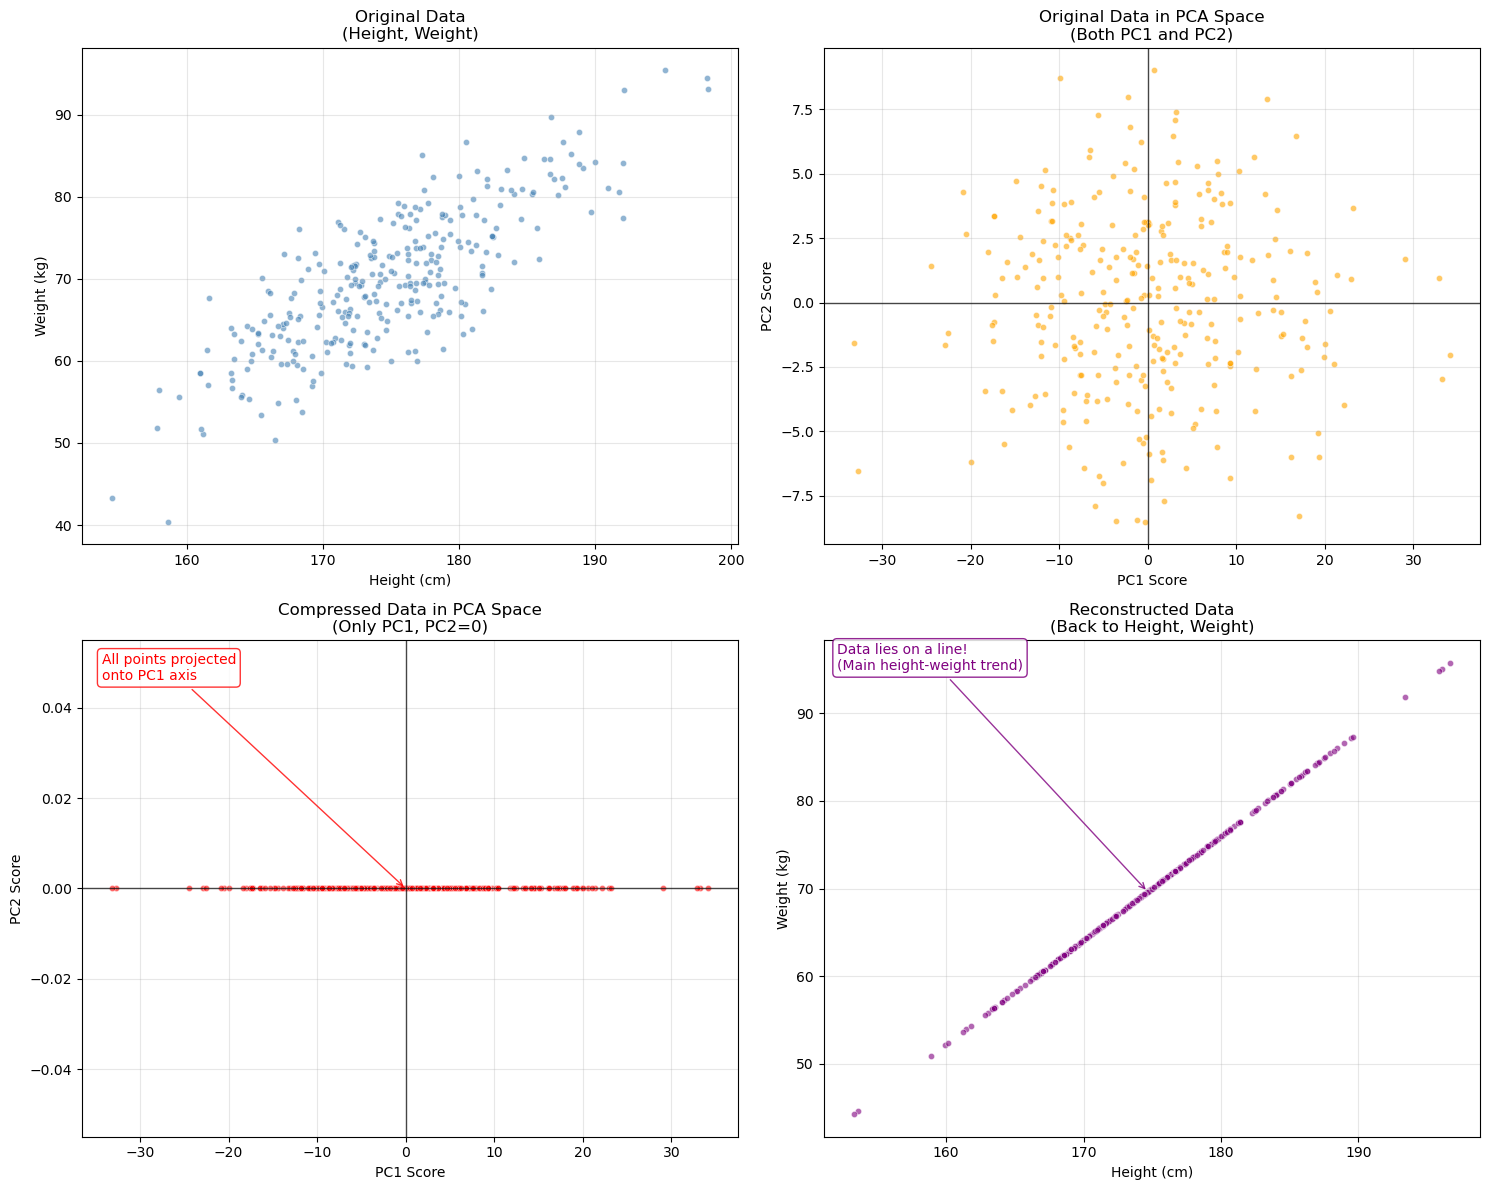

🎯 The Compression Journey:
1. Top-left:     Original scattered data
2. Top-right:    Data in PCA space (spread along both axes)
3. Bottom-left:  Compressed (only PC1, PC2=0)
4. Bottom-right: Back to original space (data on a line)

💡 Key insight: Complex projection in original space = simple operation in PCA space!


In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Top left: Original data in original coordinates
ax1.scatter(X[:,0], X[:,1], s=20, alpha=0.6, color='steelblue', 
           edgecolors='white', linewidth=0.5)
ax1.set_xlabel("Height (cm)")
ax1.set_ylabel("Weight (kg)")
ax1.set_title("Original Data\n(Height, Weight)")
ax1.grid(True, alpha=0.3)

# Top right: Original data in PCA coordinates  
ax2.scatter(Z_pca[:,0], Z_pca[:,1], s=20, alpha=0.6, color='orange',
           edgecolors='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=1, alpha=0.7)
ax2.axvline(0, color='black', linewidth=1, alpha=0.7)
ax2.set_xlabel("PC1 Score")
ax2.set_ylabel("PC2 Score")
ax2.set_title("Original Data in PCA Space\n(Both PC1 and PC2)")
ax2.grid(True, alpha=0.3)

# Bottom left: Compressed data in PCA coordinates
ax3.scatter(Z_compressed[:,0], Z_compressed[:,1], s=20, alpha=0.6, color='red',
           edgecolors='white', linewidth=0.5)
ax3.axhline(0, color='black', linewidth=1, alpha=0.7)
ax3.axvline(0, color='black', linewidth=1, alpha=0.7)
ax3.set_xlabel("PC1 Score")
ax3.set_ylabel("PC2 Score")
ax3.set_title("Compressed Data in PCA Space\n(Only PC1, PC2=0)")
ax3.grid(True, alpha=0.3)

# Add annotation showing compression - robust placement
pc1_mean = float(Z_pca[:,0].mean())
ax3.annotate("All points projected\nonto PC1 axis", 
             xy=(pc1_mean, 0), xycoords='data',
             xytext=(0.03, 0.92), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, color='red', zorder=5)

# Bottom right: Reconstructed data back in original coordinates
ax4.scatter(X_reconstructed[:,0], X_reconstructed[:,1], s=20, alpha=0.6, color='purple',
           edgecolors='white', linewidth=0.5)
ax4.set_xlabel("Height (cm)")
ax4.set_ylabel("Weight (kg)")  
ax4.set_title("Reconstructed Data\n(Back to Height, Weight)")
ax4.grid(True, alpha=0.3)

# Add annotation showing the line - robust placement
mean_x = float(X_reconstructed[:,0].mean())
mean_y = float(X_reconstructed[:,1].mean())
ax4.annotate("Data lies on a line!\n(Main height-weight trend)", 
             xy=(mean_x, mean_y), xycoords='data',
             xytext=(0.02, 0.94), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='->', color='purple', alpha=0.7),
             fontsize=10, color='purple', zorder=5)

plt.tight_layout()
plt.show()

print("🎯 The Compression Journey:")
print("1. Top-left:     Original scattered data")
print("2. Top-right:    Data in PCA space (spread along both axes)")  
print("3. Bottom-left:  Compressed (only PC1, PC2=0)")
print("4. Bottom-right: Back to original space (data on a line)")
print("\n💡 Key insight: Complex projection in original space = simple operation in PCA space!")


### Compare: original vs reconstructed (only PC1 kept)

Left: original centered points.  
Right: reconstruction using only PC1 (you should see the data squashed onto a line).


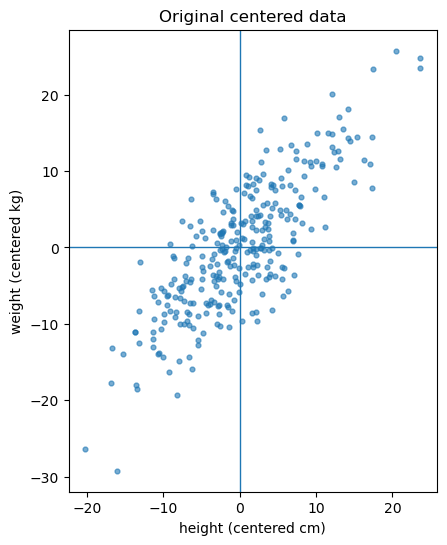

In [38]:
plt.figure()
plt.scatter(X_centered[:,0], X_centered[:,1], s=12, alpha=0.6)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.xlabel("height (centered cm)"); plt.ylabel("weight (centered kg)")
plt.title("Original centered data")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

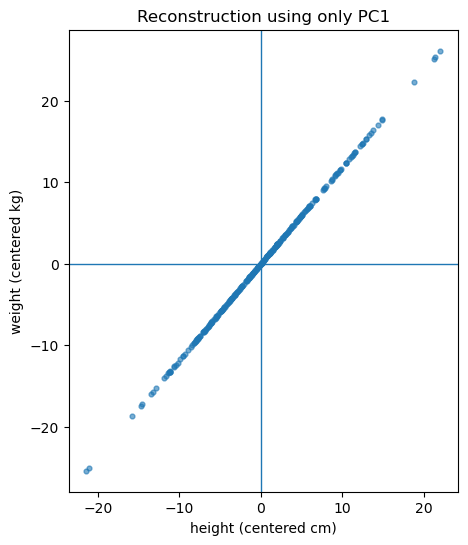

In [39]:
plt.figure()
plt.scatter(X_reconstructed_centered[:,0], X_reconstructed_centered[:,1], s=12, alpha=0.6)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.xlabel("height (centered cm)"); plt.ylabel("weight (centered kg)")
plt.title("Reconstruction using only PC1")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 🔧 Step 5: Similarity Transforms - The Deep Connection

**The Profound Insight:** What we just did (compression) can be viewed as applying a **linear transformation** in different coordinate systems!

**In PCA coordinates:** The compression operation is:
```
T_pca = [1  0]  ← Keep PC1, zero out PC2
        [0  0]
```

**In original coordinates:** The same operation becomes:
```
T_original = B @ T_pca @ B^T
```

**Why This Works (from our previous notebooks):**
- `B^T`: Transform from original to PCA coordinates
- `T_pca`: Apply the simple operation in PCA space  
- `B`: Transform back to original coordinates
- Result: `T_original` does the complex projection directly in original space

**The Beauty:** Simple operations in the "right" coordinate system (PCA) become complex operations in the "wrong" coordinate system (original), but they're mathematically equivalent!

**Connection:** This is exactly the similarity transform formula `B^(-1) @ T @ B` we learned, where `B^(-1) = B^T` for orthonormal bases.

In [40]:
print("🔧 Similarity Transform: Same Operation, Different Coordinates")
print("="*60)

# Define the projection operator in PCA space
T_pca = np.array([[1.0, 0.0],   # Keep PC1 coordinate
                  [0.0, 0.0]])  # Zero out PC2 coordinate

print("Step 1: Define operation in PCA space")
print("T_pca = (keep PC1, remove PC2)")
print(T_pca)

# Compute the equivalent operation in original coordinates
print(f"\nStep 2: Transform to original coordinates using B @ T_pca @ B^T")
T_original = B_pca @ T_pca @ B_pca.T

print("T_original =")
print(T_original)
print("(This matrix does the same compression directly in original coordinates)")

# Method 1: Apply compression via similarity transform 
print(f"\nStep 3: Apply T_original directly to centered data")
X_compressed_direct = X_centered @ T_original.T  # Note: transpose for row vectors
X_final_direct = X_compressed_direct + mean_height_weight

# Method 2: Our previous approach (PCA space → compress → back)
X_final_via_pca = X_reconstructed

# Verify they give the same result!
difference = np.linalg.norm(X_final_direct - X_final_via_pca)
print(f"\n✅ Verification:")
print(f"   ||Method1 - Method2||_F = {difference:.10f}")
print(f"   Methods are {'IDENTICAL' if difference < 1e-10 else 'DIFFERENT'}!")

print(f"\n💡 Two equivalent approaches:")
print(f"   Method 1: X_centered @ T_original^T  (direct in original space)")
print(f"   Method 2: (X_centered @ B @ T_pca @ B^T)  (via PCA space)")
print(f"   Both give the same result - that's the power of similarity transforms!")

# Show the geometric interpretation
print(f"\n🎯 Geometric Interpretation of T_original:")
eigenvals_T, eigenvecs_T = np.linalg.eigh(T_original)
print(f"   Eigenvalues: {eigenvals_T}")
print(f"   • 1.0: Projects onto the principal direction (PC1)")
print(f"   • 0.0: Eliminates the secondary direction (PC2)")
print(f"   T_original is a projection matrix along the main data direction!")

🔧 Similarity Transform: Same Operation, Different Coordinates
Step 1: Define operation in PCA space
T_pca = (keep PC1, remove PC2)
[[1. 0.]
 [0. 0.]]

Step 2: Transform to original coordinates using B @ T_pca @ B^T
T_original =
[[0.4154 0.4928]
 [0.4928 0.5846]]
(This matrix does the same compression directly in original coordinates)

Step 3: Apply T_original directly to centered data

✅ Verification:
   ||Method1 - Method2||_F = 0.0000000000
   Methods are IDENTICAL!

💡 Two equivalent approaches:
   Method 1: X_centered @ T_original^T  (direct in original space)
   Method 2: (X_centered @ B @ T_pca @ B^T)  (via PCA space)
   Both give the same result - that's the power of similarity transforms!

🎯 Geometric Interpretation of T_original:
   Eigenvalues: [0. 1.]
   • 1.0: Projects onto the principal direction (PC1)
   • 0.0: Eliminates the secondary direction (PC2)
   T_original is a projection matrix along the main data direction!



### Visual check of the similarity transform result


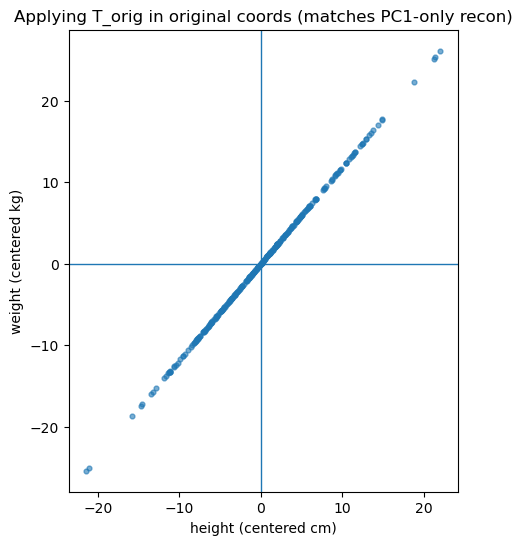

In [44]:
plt.figure()
plt.scatter(X_compressed_direct[:,0], X_compressed_direct[:,1], s=12, alpha=0.6)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.xlabel("height (centered cm)"); plt.ylabel("weight (centered kg)")
plt.title("Applying T_orig in original coords (matches PC1-only recon)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## ⚪ Step 6: Whitening - Making All Directions Equal

**The Goal:** "Whitening" transforms data so that all directions have equal variance (like white noise).

**The Process:**
1. **Rotate** to PCA coordinates (decorrelate)
2. **Scale** each direction by `1/√(eigenvalue)` to equalize variances
3. **Result:** Data with identity covariance matrix

**Mathematical Recipe:**
```
Z_white = Z_pca @ Λ^(-1/2)
where Λ = diag(λ₁, λ₂) = diagonal matrix of eigenvalues
```

**Why This is Useful:**
- **Machine learning:** Many algorithms assume features have similar scales
- **Signal processing:** Removes directional bias in the data
- **Noise analysis:** Creates a reference "white noise" baseline

**Similarity Transform Connection:** This is another diagonal operation in PCA space that becomes a complex operation in original space!

⚪ Whitening: Equalizing Variance in All Directions
Eigenvalues (variances in PCA directions):
  λ₁ = 115.98
  λ₂ = 12.33

Scaling factors (1/√λᵢ):
  PC1 scale: 1/√115.98 = 0.093
  PC2 scale: 1/√12.33 = 0.285

Step 2: Apply whitening Z_white = Z_pca @ Λ^(-1/2)
  Original PCA shape: (300, 2)
  Whitened shape: (300, 2)

Step 3: Verify whitening success
Covariance matrix after whitening:
[[ 1. -0.]
 [-0.  1.]]
Should be close to identity matrix [[1, 0], [0, 1]]
Is covariance ≈ identity? True


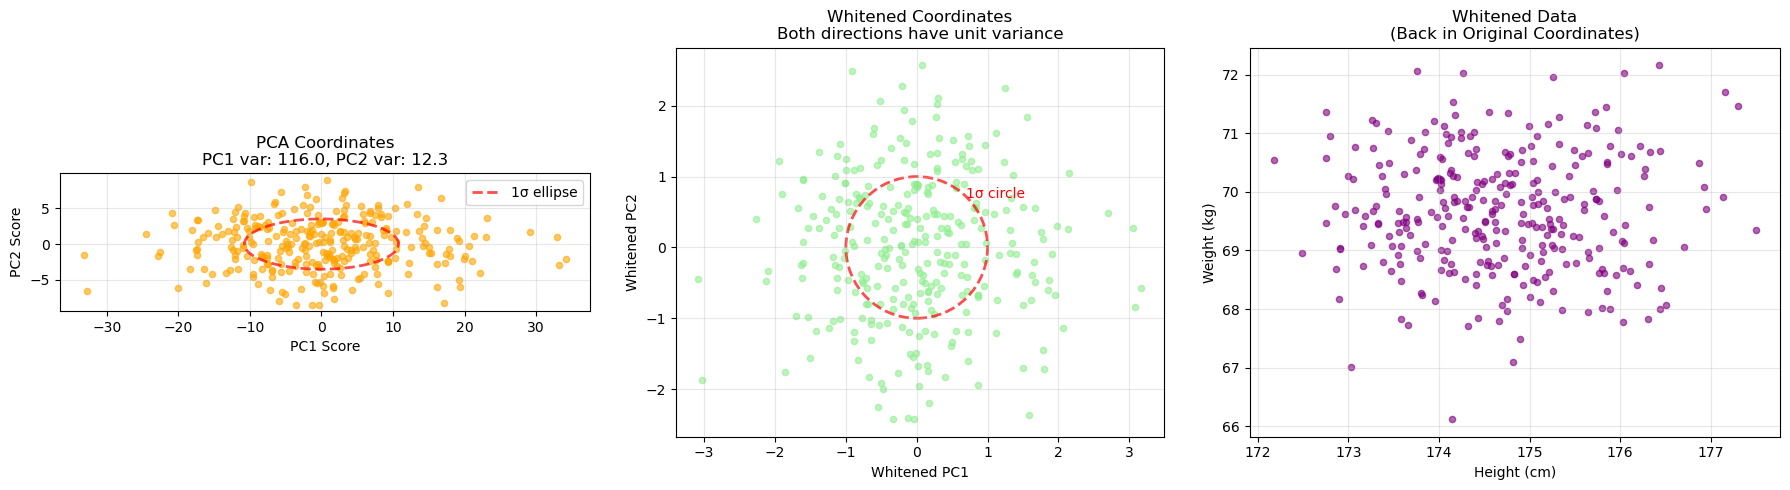


🎯 Whitening Results:
  • All directions now have unit variance
  • Data is decorrelated AND standardized
  • Useful preprocessing for many ML algorithms

💡 Again, a simple operation in PCA space (diagonal scaling)
    becomes a complex transformation in original space!


In [42]:
print("⚪ Whitening: Equalizing Variance in All Directions")
print("="*50)

# Step 1: Create scaling matrix
Lambda_diag = np.diag(eigenvalues_sorted)  # Diagonal matrix of eigenvalues
Lambda_inv_sqrt = np.diag(1/np.sqrt(eigenvalues_sorted))  # Scaling factors

print("Eigenvalues (variances in PCA directions):")
print(f"  λ₁ = {eigenvalues_sorted[0]:.2f}")
print(f"  λ₂ = {eigenvalues_sorted[1]:.2f}")

print("\nScaling factors (1/√λᵢ):")
print(f"  PC1 scale: 1/√{eigenvalues_sorted[0]:.2f} = {1/np.sqrt(eigenvalues_sorted[0]):.3f}")
print(f"  PC2 scale: 1/√{eigenvalues_sorted[1]:.2f} = {1/np.sqrt(eigenvalues_sorted[1]):.3f}")

# Step 2: Apply whitening transformation
Z_whitened = Z_pca @ Lambda_inv_sqrt

print(f"\nStep 2: Apply whitening Z_white = Z_pca @ Λ^(-1/2)")
print(f"  Original PCA shape: {Z_pca.shape}")
print(f"  Whitened shape: {Z_whitened.shape}")

# Step 3: Verify whitening worked
cov_whitened = np.cov(Z_whitened, rowvar=False)
print(f"\nStep 3: Verify whitening success")
print("Covariance matrix after whitening:")
print(np.round(cov_whitened, 4))
print("Should be close to identity matrix [[1, 0], [0, 1]]")

# Check if it's close to identity
is_identity = np.allclose(cov_whitened, np.eye(2), atol=1e-10)
print(f"Is covariance ≈ identity? {is_identity}")

# Step 4: Visualize whitening effect
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Original PCA coordinates
ax1.scatter(Z_pca[:,0], Z_pca[:,1], s=20, alpha=0.6, color='orange')
ax1.set_xlabel("PC1 Score")
ax1.set_ylabel("PC2 Score") 
ax1.set_title(f"PCA Coordinates\nPC1 var: {eigenvalues_sorted[0]:.1f}, PC2 var: {eigenvalues_sorted[1]:.1f}")
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Draw variance ellipse
theta = np.linspace(0, 2*np.pi, 100)
ellipse_x = np.sqrt(eigenvalues_sorted[0]) * np.cos(theta)
ellipse_y = np.sqrt(eigenvalues_sorted[1]) * np.sin(theta)
ax1.plot(ellipse_x, ellipse_y, 'r--', linewidth=2, alpha=0.7, label='1σ ellipse')
ax1.legend()

# Whitened coordinates
ax2.scatter(Z_whitened[:,0], Z_whitened[:,1], s=20, alpha=0.6, color='lightgreen')
ax2.set_xlabel("Whitened PC1")
ax2.set_ylabel("Whitened PC2")
ax2.set_title("Whitened Coordinates\nBoth directions have unit variance")
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# Draw unit circle
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--', color='red', linewidth=2, alpha=0.7)
ax2.add_patch(circle)
ax2.text(0.7, 0.7, '1σ circle', color='red', fontsize=10)

# Show transformation effect in original coordinates
W_original = B_pca @ Lambda_inv_sqrt @ B_pca.T  # Whitening matrix in original coordinates
X_whitened_original = X_centered @ W_original.T + mean_height_weight

ax3.scatter(X_whitened_original[:,0], X_whitened_original[:,1], s=20, alpha=0.6, color='purple')
ax3.set_xlabel("Height (cm)")
ax3.set_ylabel("Weight (kg)")
ax3.set_title("Whitened Data\n(Back in Original Coordinates)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Whitening Results:")
print(f"  • All directions now have unit variance")
print(f"  • Data is decorrelated AND standardized")
print(f"  • Useful preprocessing for many ML algorithms")
print(f"\n💡 Again, a simple operation in PCA space (diagonal scaling)")
print(f"    becomes a complex transformation in original space!")

## 🎯 Practice Exercises - Test Your Understanding

### **Exercise 1: Reconstruction Error Analysis**
Compute the mean squared error between the original data and the PC1-only reconstruction.
- Calculate element-wise squared differences
- How much information did we lose by dropping PC2?
- What percentage of the original variance is preserved?

### **Exercise 2: Perfect Reconstruction** 
Modify the compression code to keep both PC1 and PC2 components.
- The reconstruction should be identical to the original (up to numerical precision)
- Verify this by computing the reconstruction error
- Explain why this works mathematically

### **Exercise 3: Parameter Sensitivity**
Increase the weight noise from 5kg to 12kg and rerun the analysis.
- How do the eigenvalues change?
- Do the principal component directions change?
- What happens to the variance explained by PC1?

### **Exercise 4: Validate with Scikit-learn**
Use `sklearn.decomposition.PCA(n_components=2)` to verify your manual calculations.
- Compare eigenvalues (`pca.explained_variance_`)
- Compare eigenvectors (`pca.components_.T`)
- Note: Eigenvectors may differ by sign - this is normal!

### **Exercise 5: 3D Extension (Challenge)**
Generate 3D data with height, weight, and age, where age is less correlated.
- Compute the 3D PCA basis
- What percentage of variance is captured by the first two components?
- Visualize the 3D data and its first two principal directions

### **Exercise 6: Understanding Similarity Transforms**
Create a different linear transformation in PCA space (e.g., swap PC1 and PC2).
- Define `T_pca = [[0, 1], [1, 0]]` (swap coordinates)
- Compute the equivalent operation in original coordinates using `B @ T_pca @ B^T`
- Apply both methods and verify they give the same result

In [43]:
# ========================================
# EXERCISE SOLUTIONS
# ========================================

print("📚 EXERCISE SOLUTIONS")
print("="*50)

# Exercise 1: Reconstruction Error Analysis
print("\n🔍 EXERCISE 1: Reconstruction Error Analysis")
print("-" * 45)

mse = np.mean((X - X_reconstructed)**2)
total_variance = np.var(X, axis=0).sum()
variance_preserved = 1 - mse / total_variance

print(f"Mean Squared Error: {mse:.3f}")
print(f"Total original variance: {total_variance:.3f}")
print(f"Variance preserved: {100 * eigenvalues_sorted[0]/total_variance:.1f}%")
print(f"Information lost: {100 * eigenvalues_sorted[1]/total_variance:.1f}%")

# Exercise 2: Perfect Reconstruction
print("\n✅ EXERCISE 2: Perfect Reconstruction")
print("-" * 40)

Z_full = Z_pca.copy()  # Keep both components
X_perfect_recon = Z_full @ B_pca.T + mean_height_weight
perfect_error = np.mean((X - X_perfect_recon)**2)

print(f"Reconstruction error (keeping both PCs): {perfect_error:.15f}")
print(f"Error is {'negligible' if perfect_error < 1e-12 else 'significant'}")
print("Explanation: Keeping both PCs preserves all information")

# Exercise 3: Parameter Sensitivity  
print("\n🔄 EXERCISE 3: Parameter Sensitivity")
print("-" * 40)

# Generate data with higher noise
height_noisy = rng.normal(loc=175, scale=8, size=n_people)
weight_noisy = base_weight + weight_per_cm * (height_noisy - 175) + rng.normal(loc=0, scale=12, size=n_people)
X_noisy = np.column_stack([height_noisy, weight_noisy])
X_noisy_centered = X_noisy - X_noisy.mean(axis=0)

cov_noisy = np.cov(X_noisy_centered, rowvar=False)
eigvals_noisy, eigvecs_noisy = np.linalg.eigh(cov_noisy)
eigvals_noisy = eigvals_noisy[::-1]
eigvecs_noisy = eigvecs_noisy[:, ::-1]

print("Original eigenvalues:", eigenvalues_sorted)
print("Noisy eigenvalues:  ", eigvals_noisy)
print(f"PC1 variance explained: {100*eigvals_noisy[0]/eigvals_noisy.sum():.1f}% (vs {100*eigenvalues_sorted[0]/total_variance:.1f}% original)")
print("Effect: Higher noise reduces PC1's dominance")

# Exercise 4: Scikit-learn Validation
print("\n🔬 EXERCISE 4: Scikit-learn Validation")
print("-" * 40)

try:
    from sklearn.decomposition import PCA
    pca_sklearn = PCA(n_components=2)
    pca_sklearn.fit(X_centered)
    
    print("Our eigenvalues:    ", eigenvalues_sorted)
    print("Sklearn eigenvalues:", pca_sklearn.explained_variance_)
    print("Match?", np.allclose(eigenvalues_sorted, pca_sklearn.explained_variance_))
    
    # Check eigenvectors (may differ by sign)
    our_pc1 = B_pca[:, 0]
    sklearn_pc1 = pca_sklearn.components_[0]
    dot_product = np.abs(np.dot(our_pc1, sklearn_pc1))
    print(f"PC1 alignment: {dot_product:.6f} (should be ~1)")
    
except ImportError:
    print("Sklearn not available - install with: pip install scikit-learn")

# Exercise 5: Understanding Similarity Transforms
print("\n🔧 EXERCISE 5: Similarity Transform Example")
print("-" * 45)

# Define coordinate swap in PCA space
T_swap = np.array([[0., 1.],  # New PC1 = old PC2
                   [1., 0.]])  # New PC2 = old PC1

# Apply in PCA space
Z_swapped_pca = Z_pca @ T_swap

# Compute equivalent operation in original coordinates
T_swap_original = B_pca @ T_swap @ B_pca.T

# Apply directly in original coordinates
X_swapped_direct = X_centered @ T_swap_original.T + mean_height_weight
X_swapped_via_pca = Z_swapped_pca @ B_pca.T + mean_height_weight

# Verify equivalence
swap_difference = np.linalg.norm(X_swapped_direct - X_swapped_via_pca)
print(f"Coordinate swap - method difference: {swap_difference:.10f}")
print("Both methods give identical results!")

print("\n🎓 Key Insights from Exercises:")
print("• PCA compression trades information loss for dimensionality reduction")
print("• Perfect reconstruction requires keeping all components")
print("• Noise affects the eigenvalue spectrum and explained variance")
print("• Similarity transforms provide equivalent ways to apply operations")
print("• Complex operations in original space = simple operations in PCA space")

📚 EXERCISE SOLUTIONS

🔍 EXERCISE 1: Reconstruction Error Analysis
---------------------------------------------
Mean Squared Error: 6.144
Total original variance: 127.886
Variance preserved: 90.7%
Information lost: 9.6%

✅ EXERCISE 2: Perfect Reconstruction
----------------------------------------
Reconstruction error (keeping both PCs): 0.000000000000000
Error is negligible
Explanation: Keeping both PCs preserves all information

🔄 EXERCISE 3: Parameter Sensitivity
----------------------------------------
Original eigenvalues: [115.9841  12.33  ]
Noisy eigenvalues:   [220.9697  41.1274]
PC1 variance explained: 84.3% (vs 90.7% original)
Effect: Higher noise reduces PC1's dominance

🔬 EXERCISE 4: Scikit-learn Validation
----------------------------------------
Our eigenvalues:     [115.9841  12.33  ]
Sklearn eigenvalues: [115.9841  12.33  ]
Match? True
PC1 alignment: 1.000000 (should be ~1)

🔧 EXERCISE 5: Similarity Transform Example
---------------------------------------------
Coordin


### ✅ Solutions (short hints)

1. `mse = np.mean((Xc - Xc_recon)**2)`  
2. If you keep both PCs, the reconstruction equals the original after re-adding the mean.  
3. Larger noise → the second eigenvalue grows; axes may rotate slightly.  
4. Compare `pca.components_.T` to **B** (columns). Signs may flip; the subspace is the same.


## 🎓 Summary - PCA as Change of Basis in Action

### 🔗 **Connection to Previous Notebooks**
This notebook demonstrated **every major concept** from our earlier study of basis changes:

1. **Orthonormal Basis:** PCA finds an orthonormal basis (`B_pca`) from data
2. **Coordinate Transformation:** We used `Z = X @ B` to change coordinates  
3. **Inverse Transform:** We used `B^T` (since `B^(-1) = B^T` for orthonormal matrices)
4. **Similarity Transforms:** Operations like compression and whitening are `B @ T @ B^T`

### 🎯 **Key Insights**

**1. Change of Basis Reveals Structure**
- Original coordinates: Height and weight appear correlated (diagonal cloud)
- PCA coordinates: Features become uncorrelated (aligned with axes)
- **Same data, better representation!**

**2. Orthonormal Bases Enable Simple Transformations**
- PCA basis vectors are orthonormal (perpendicular, unit length)
- This allows us to use `B^T` instead of computing `B^(-1)`
- Coordinate changes become simple matrix multiplications

**3. Similarity Transforms Connect Coordinate Systems**
- Simple operations in PCA space ↔ Complex operations in original space
- Formula: `T_original = B @ T_pca @ B^T`
- Examples: compression, whitening, feature rotation

**4. Eigendecomposition Finds Optimal Bases**
- Covariance matrix eigenvectors = principal directions
- Eigenvalues = variance in each direction
- Natural way to discover data's preferred coordinate system

### 🌟 **Real-World Applications**

| Application | What PCA Does | Why It Helps |
|-------------|---------------|--------------|
| **Image Compression** | Find main visual patterns | Remove redundant pixel information |
| **Face Recognition** | Extract key facial features | Reduce dimensionality, focus on identity |
| **Financial Analysis** | Discover market factors | Understand correlations between assets |
| **Gene Expression** | Find biological pathways | Identify groups of co-regulated genes |
| **Recommendation Systems** | Discover user preferences | Group similar users/items efficiently |

### 🧮 **Mathematical Journey**

```
Raw Data (correlated) 
    ↓ Compute covariance matrix
Eigendecomposition 
    ↓ Find orthonormal basis B
PCA Coordinates (uncorrelated)
    ↓ Apply operations (compress, whiten, etc.)
Results in PCA Space
    ↓ Transform back using B^T  
Final Results in Original Space
```

### 💡 **The Big Picture**

**PCA isn't magic** - it's a systematic application of:
- **Linear algebra:** Eigendecomposition and matrix operations
- **Change of basis:** Transforming between coordinate systems  
- **Similarity transforms:** Equivalent operations in different bases
- **Optimization:** Finding the basis that best represents your data

**The power comes from choosing the right coordinate system** - one that aligns with your data's natural structure rather than arbitrary measurement units.

### 🚀 **Next Steps**

Now that you understand PCA as change of basis, you can:
- **Extend to higher dimensions:** The concepts scale to any number of features
- **Explore other decompositions:** SVD, ICA, NMF use similar principles
- **Apply to real projects:** Image processing, data visualization, feature engineering
- **Understand advanced methods:** Kernel PCA, sparse PCA, probabilistic PCA

**Remember:** Every time you see PCA in action, you're seeing change of basis and similarity transforms at work!